# Policy Lab Data Science Intern Performance Task
## By TzuHwan Seet

In [3]:
# libraries 
import pandas as pd

## Question 1: How many people live in Boston?

In [5]:
# read in data
population_by_blockgroup_df = pd.read_csv("data/population_by_blockgroup.csv")
population_by_blockgroup_df.head()

,state,county,tract,blockgroup,city,GEOID10,B01001_001E,B01001_002E,B01001_003E,B01001_004E,...,B01001_040E,B01001_041E,B01001_042E,B01001_043E,B01001_044E,B01001_045E,B01001_046E,B01001_047E,B01001_048E,B01001_049E
0,25,9,252602,4,Methuen Town,250092526024,1824,999,56,95,...,74,45,59,30,7,28,52,27,7,10
1,25,5,641300,5,Fall River,250056413005,1012,583,85,13,...,43,22,15,36,0,0,13,17,0,14
2,25,27,710600,5,Fitchburg,250277106005,1917,991,0,152,...,96,9,15,13,0,14,6,55,0,14
3,25,17,353000,3,Cambridge,250173530003,1065,526,46,17,...,67,10,14,6,0,7,31,46,31,23
4,25,25,50901,2,Boston,250250509012,1726,943,0,10,...,39,36,11,29,9,0,18,15,0,0


In [26]:
# check for any nan values in the csv 
if population_by_blockgroup_df.isnull().sum().sum() == 0:
    print("No nan values in dataframe")
else:
    print("nan values in dataframe")

No nan values in dataframe


In [15]:
# Total people who live in Boston = SUM(B01001_001E) GROUP BY GEOID10 WHERE city='Boston'
boston_population = population_by_blockgroup_df[population_by_blockgroup_df["city"]=="Boston"]
print("Boston population: ", boston_population["B01001_001E"].sum())


Boston population:  684379


## Question 2: How many people who are at least 65 years old live in Boston?

In [67]:
code_for_65_above_with_GEOID10 = [
    "B01001_020E", "B01001_021E", "B01001_022E", "B01001_023E", "B01001_024E",
    "B01001_025E", "B01001_044E", "B01001_045E", "B01001_046E", "B01001_047E",
    "B01001_048E", "B01001_049E", "GEOID10"
]

# return the codes and GEOID10
boston_65_and_above_population = boston_population[code_for_65_above_with_GEOID10]
total_boston_65_and_above_count = boston_65_and_above_population.iloc[:, :-1].sum().sum()
print("Number of people who are at least 65 years old who live in Boston: ", total_boston_65_and_above_count)

Number of people who are at least 65 years old who live in Boston:  78861


## Question 3: How many people who are at least 65 years old live within one mile of Fenway High School in Boston?

In [68]:
# needs a list of census block groups that are <= 1 mile of Fenway High School
distance_from_school_df = pd.read_csv("data/distance_from_school_to_blockgroup_in_miles.csv")
blockgroups_within_1_mile_from_fenway_school = distance_from_school_df[
    (distance_from_school_df["school_name"] == "Fenway High School")
    & (distance_from_school_df["distance"] <= 1)]["GEOID10"].tolist()

# extract individuals from the block group list from boston_65_and_above_population
boston_65_and_above_within_1_mile_from_fenway_school_population = boston_65_and_above_population[boston_65_and_above_population["GEOID10"].isin(blockgroups_within_1_mile_from_fenway_school)]

print(
    "Number of people who are at least 65 years old who live within one mile of Fenway High School in Boston: ",
    boston_65_and_above_within_1_mile_from_fenway_school_population.iloc[:, :-1].sum().sum())


Number of people who are at least 65 years old who live within one mile of Fenway High School in Boston:  5419


## Question 4: What is the mean distance a resident of Boston who is at least 65 years old lives from their nearest school?

In [96]:
# a helper method that takes in block group code and returns the shortest school distance to the block group
def findClosestSchoolDistance(block_group):
    return distance_from_school_df[distance_from_school_df["GEOID10"]==block_group]["distance"].min()

boston_65_and_above_population["closest_school_distance"] = boston_65_and_above_population.apply(lambda x: findClosestSchoolDistance(x["GEOID10"]), axis=1)

total_distance = boston_65_and_above_population["closest_school_distance"].sum()
number_of_block_groups = len(boston_65_and_above_population.index)

print(
    "mean distance of a resident of Boston who is at least 65 years old lives from their nearest school: ", round(total_distance/number_of_block_groups, 3)
)


mean distance of a resident of Boston who is at least 65 years old lives from their nearest school:  0.323


<ipython-input-96-8c84cb3ddebe>:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  boston_65_and_above_population["closest_school_distance"] = boston_65_and_above_population.apply(lambda x: findClosestSchoolDistance(x["GEOID10"]), axis=1)


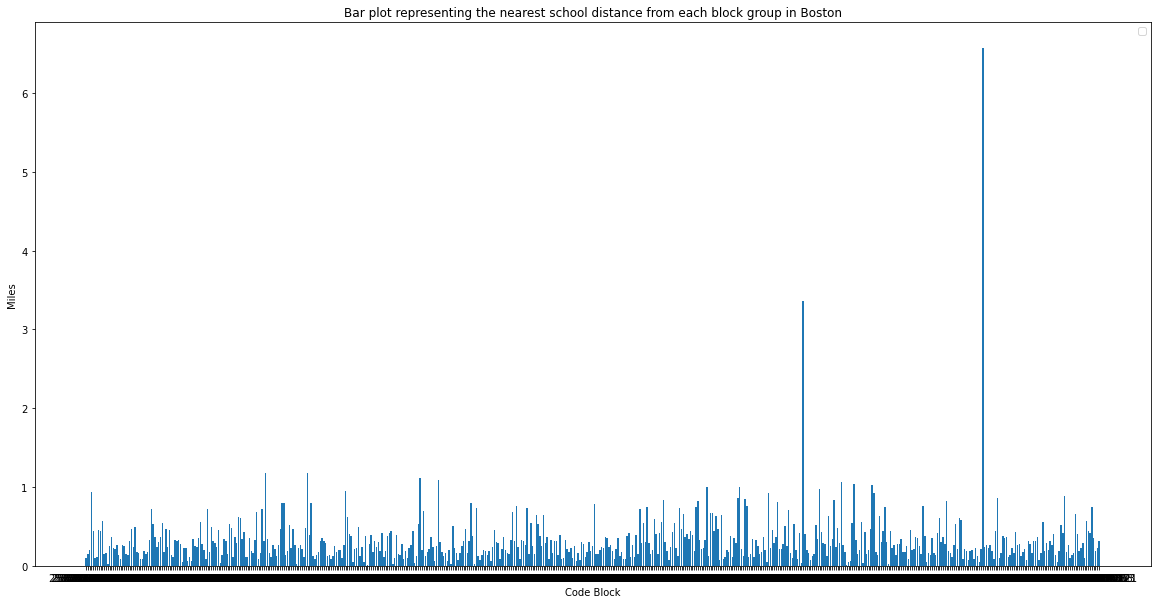

In [98]:
import matplotlib.pyplot as plt

block_group_list = boston_65_and_above_population["GEOID10"].astype(str).to_list()
closest_school_distance = pd.to_numeric(boston_65_and_above_population["closest_school_distance"]).to_list()

plt.figure(figsize=(20, 10))

plt.title(
    "Bar plot representing the nearest school distance from each block group in Boston"
)
plt.legend(labels=['Nearest School Distance'])
plt.xlabel('Code Block')
plt.ylabel('Miles')

plt.bar(block_group_list, closest_school_distance)
plt.show()